In [1]:
# C4T3

library('doParallel')

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [2]:
library('caret')

Loading required package: lattice

Loading required package: ggplot2



In [3]:
library('catboost')
library('corrplot')

corrplot 0.84 loaded



In [4]:
library('plotly')


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout




In [5]:
detectCores() # Result = Typically 4 to 6

[1] 12

In [6]:
# Setting a number of cores used for the cluster
cl <- makeCluster(10)

# Register Cluster
registerDoParallel(cl)

# Confirm how many cores are now "assigned" to R and RStudio
getDoParWorkers() # Result 2 

# Stop Cluster. After performing your tasks, stop your cluster. 
# stopCluster(cl)

[1] 10

<b>Exploring the Data</b>

In [7]:
iphone <- read.csv('iphone_smallmatrix_labeled_8d.csv')

In [8]:
head(iphone)

iphone,samsunggalaxy,sonyxperia,nokialumina,htcphone,ios,googleandroid,iphonecampos,samsungcampos,sonycampos,...,sonyperunc,nokiaperunc,htcperunc,iosperpos,googleperpos,iosperneg,googleperneg,iosperunc,googleperunc,iphonesentiment
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41,0,0,0,0,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4


In [9]:
iphone$iphonesentiment <- as.factor(iphone$iphonesentiment)

# str(iphone)

In [10]:
# summary(iphone)

In [11]:
sum(is.na(iphone))

[1] 0

In [12]:
# p <- plot_ly(iphone, x= ~iphone['iphonesentiment'], type='histogram')

# embed_notebook(p)

# hist(iphone$iphonesentiment,  breaks = 8, xlim = c(0,6), main = 'Sendiments distribution', col="chocolate")

'data.frame':	12973 obs. of  46 variables:
 $ samsunggalaxy  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonyxperia     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokialumina    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ios            : int  0 0 0 0 0 6 0 0 0 0 ...
 $ googleandroid  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecampos   : int  0 0 0 0 0 1 1 0 0 0 ...
 $ samsungcampos  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycampos     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccampos      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamneg   : int  0 0 0 0 0 3 1 0 0 0 ...
 $ samsungcamneg  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamneg     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacamneg    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccamneg      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamunc   : int  0 0 0 0 0 7 1 0 0 0 ...
 $ samsungcamunc  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamunc     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccamunc      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonedispos   : int  0 0 0 0 0 1 13 0 0 0 ...
 $ sonydispos     : int  

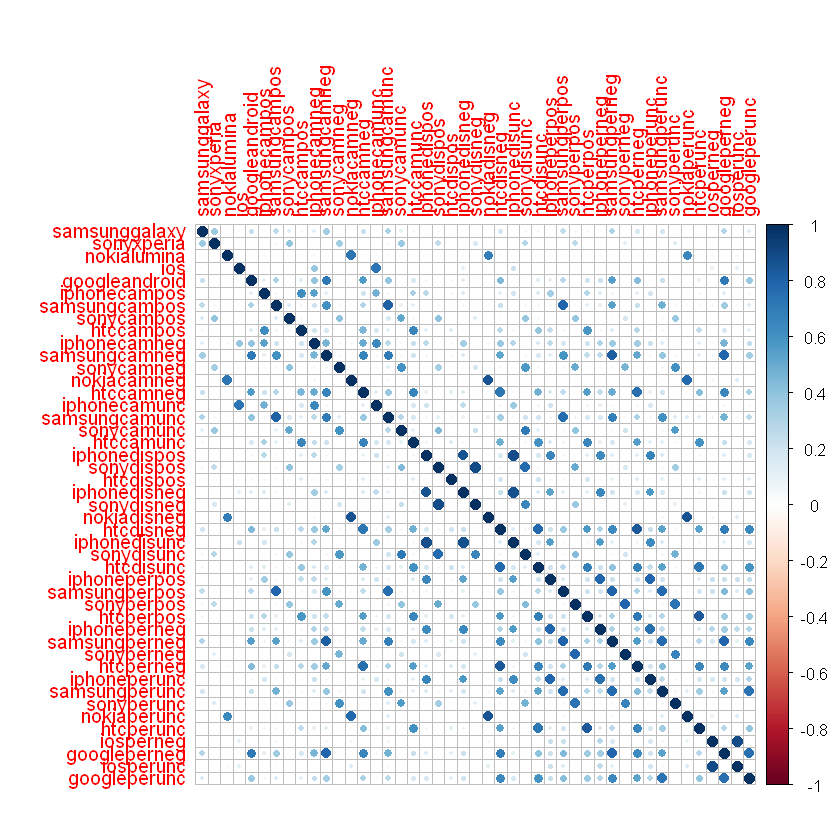

In [13]:
# Feature selection. Remove highly correlated (>0.9) independent variables

iph_tmp <- iphone[, 1:(ncol(iphone)-1)]

tmp <- cor(iphone[, 1:(ncol(iphone)-1)])

tmp[upper.tri(tmp)] <- 0

diag(tmp) <- 0

iphone.f_corr <- iph_tmp[,!apply(tmp,2,function(x) any(x >= 0.90))]

corrplot(cor(iphone.f_corr))


iphone.f_corr$iphonesentiment <- iphone$iphonesentiment
                                
str(iphone.f_corr)
                                
# number of variables shortened from 58 to 45

In [14]:
# Feature selection. Remove zero variance columns

iphone.f_zv <- iphone[ , apply(iphone, 2, var) != 0]


str(iphone.f_zv)
# number of variables kept the same

'data.frame':	12973 obs. of  59 variables:
 $ iphone         : int  1 1 1 1 1 41 1 1 1 1 ...
 $ samsunggalaxy  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonyxperia     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokialumina    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htcphone       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ios            : int  0 0 0 0 0 6 0 0 0 0 ...
 $ googleandroid  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecampos   : int  0 0 0 0 0 1 1 0 0 0 ...
 $ samsungcampos  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycampos     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacampos    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccampos      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamneg   : int  0 0 0 0 0 3 1 0 0 0 ...
 $ samsungcamneg  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamneg     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacamneg    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccamneg      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamunc   : int  0 0 0 0 0 7 1 0 0 0 ...
 $ samsungcamunc  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamunc     : int  


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         1   0.6659 0.2594    0.02312 0.06081         
         2   0.6795 0.3121    0.02775 0.07446         
         3   0.6815 0.3189    0.02683 0.07218         
         4   0.7139 0.4120    0.03230 0.07984         
         5   0.7164 0.4247    0.03241 0.07779         
         6   0.7269 0.4471    0.03302 0.07644         
         7   0.7394 0.4746    0.03653 0.08515         
         8   0.7401 0.4724    0.03326 0.08104         
         9   0.7588 0.5242    0.04262 0.09260         
        10   0.7646 0.5339    0.03850 0.08661         
        11   0.7660 0.5362    0.03524 0.08197         
        12   0.7640 0.5308    0.03715 0.08579         
        13   0.7640 0.5298    0.03746 0.08626         
        14   0.7666 0.5350    0.03639 0.08467         
        15   0.7644 0.5302    0.

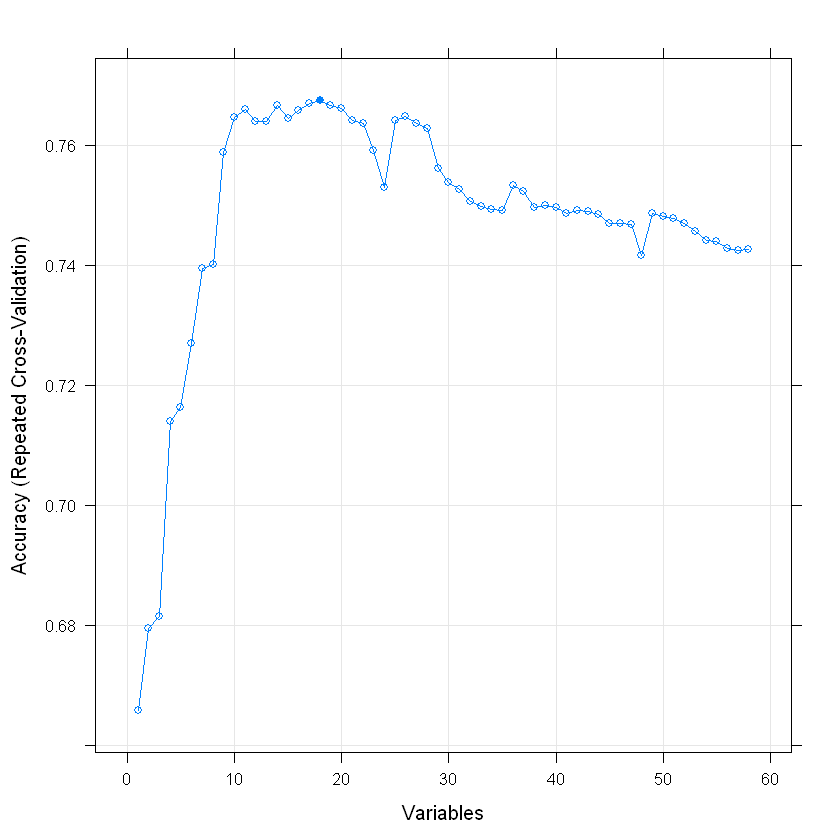

In [15]:
# Feature selection. Recursive Feature Elimination

set.seed(123)
iphoneSample <- iphone[sample(1:nrow(iphone), 1000, replace=FALSE),]

# Set up rfeControl with randomforest, repeated cross validation and no updates
ctrl <- rfeControl(functions = rfFuncs, 
                   method = "repeatedcv",
                   repeats = 5,
                   verbose = FALSE)

# Use rfe and omit the response variable (attribute 59 iphonesentiment) 
rfeResults <- rfe(iphoneSample[,1:(ncol(iphone)-1)], 
                  iphoneSample$iphonesentiment, 
                  sizes=(1:(ncol(iphone)-1)), 
                  rfeControl=ctrl)

# Get results
rfeResults

# Plot results
plot(rfeResults, type=c("g", "o"))

In [16]:
# create new data set with rfe recommended features
iphoneRFE <- iphone[,predictors(rfeResults)]

# add the dependent variable to iphoneRFE
iphoneRFE$iphonesentiment <- iphone$iphonesentiment

# review outcome
str(iphoneRFE)

'data.frame':	12973 obs. of  19 variables:
 $ iphone         : int  1 1 1 1 1 41 1 1 1 1 ...
 $ samsunggalaxy  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ googleandroid  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonedisunc   : int  0 0 0 0 0 4 9 0 0 0 ...
 $ iphonedispos   : int  0 0 0 0 0 1 13 0 0 0 ...
 $ iphonedisneg   : int  0 0 0 0 0 3 10 0 0 0 ...
 $ htcphone       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamneg   : int  0 0 0 0 0 3 1 0 0 0 ...
 $ iphoneperpos   : int  0 1 0 1 1 0 5 3 0 0 ...
 $ ios            : int  0 0 0 0 0 6 0 0 0 0 ...
 $ sonyxperia     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphoneperunc   : int  0 0 0 1 0 0 5 0 0 0 ...
 $ iphonecamunc   : int  0 0 0 0 0 7 1 0 0 0 ...
 $ iphoneperneg   : int  0 0 0 0 0 0 4 1 0 0 ...
 $ htcperpos      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecampos   : int  0 0 0 0 0 1 1 0 0 0 ...
 $ htccampos      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htcperneg      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonesentiment: Factor w/ 6 levels "0","1","2","3",..: 1 1 1 1 1 5 5

<b>Modeling</b>

In [17]:
partition <- createDataPartition(iphone$iphonesentiment, p = .70, list = FALSE)
training <- iphone[partition,]
testing <- iphone[-partition,]

In [18]:
# Set 5 folds for cross-validation

fitControl0 <- trainControl(method = "repeatedcv", number = 5, repeats = 1)

In [19]:
# Train C5.0 model

C5Fit <- train(iphonesentiment~., data = training, method = "C5.0", metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

C5Pred <- predict(C5Fit, testing)

postResample(C5Pred, testing$iphonesentiment)

Accuracy     Kappa 
0.7701799 0.5533155

In [20]:
# Train Random Forest model

rfFit <- train(iphonesentiment~., data = training, method = "rf", metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

rfPred <- predict(rfFit, testing)

postResample(rfPred, testing$iphonesentiment)

Accuracy     Kappa 
0.7742931 0.5623859

In [21]:
# Train Linear Support Vector Machines
library('e1071')


svmFit <- svm(iphonesentiment~., data = training, kernel =
"linear", metric = 'Kappa', scale = TRUE, trControl=fitControl0, tuneLength = 1)

svmPred <- predict(svmFit, testing)

postResample(svmPred, testing$iphonesentiment)

Accuracy     Kappa 
0.7120823 0.4175725

In [22]:
# Train k-NN
# install.packages('kknn')

kknnFit <- train(iphonesentiment~., data = training, method = "kknn", preProcess = c("center", "scale"), metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

kknnPred <- predict(kknnFit, testing)

postResample(kknnPred, testing$iphonesentiment)

Accuracy     Kappa 
0.3071979 0.1523470

In [23]:
# library('catboost')

# labels <- as.numeric(training$iphonesentiment)

# labels_test <- as.numeric(testing$iphonesentiment)

# cat_training <- training[, 1:(ncol(training)-1)]
# cat_training <- sapply(cat_training, as.numeric)

# cat_testing <- testing[, 1:(ncol(training)-1)]
# cat_testing <- sapply(cat_testing, as.numeric)


# fit_params <- list(iterations = 5000,
#                    loss_function = 'CrossEntropy',
#                   eval_metric = 'Kappa',
#                   task_type = 'CPU',
#                   random_seed = 123)

# train_pool <- catboost.load_pool(cat_training, label = labels)

# test_pool <- catboost.load_pool(cat_testing, label = labels_test)

# # catFit <- catboost.train(train_pool, params = fit_params)

# catFit <- catboost.train(train_pool, test_pool, params = fit_params)

# catPred <- catboost.predict(catFit, 
#                  test_pool)

# postResample(catPred, labels_test)

In [24]:
# catPred <- catboost.predict(catFit, 
#                  test_pool)

The best "out-of-the-box" model is Random Forest. Let's apply it to feature selected datasets

In [25]:
# Apply to a dataset where highly correlated variables are dropped

partition_fcorr <- createDataPartition(iphone.f_corr$iphonesentiment, p = .70, list = FALSE)

training_fcorr <- iphone.f_corr[partition_fcorr,]
testing_fcorr <- iphone.f_corr[-partition_fcorr,]

# Train Random Forest model

rfcFit <- train(iphonesentiment~., data = training_fcorr, method = "rf", metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

rfcPred <- predict(rfcFit, testing_fcorr)

postResample(rfcPred, testing_fcorr$iphonesentiment)

Accuracy     Kappa 
0.7367609 0.4920231

In [26]:
# Apply to a dataset where variables are those selected by Recursive Feature Elimination

partition_rfe <- createDataPartition(iphoneRFE$iphonesentiment, p = .70, list = FALSE)

training_rfe <- iphoneRFE[partition_rfe,]
testing_rfe <- iphoneRFE[-partition_rfe,]

# Train Random Forest model

rfeFit <- train(iphonesentiment~., data = training_rfe, method = "rf", metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

rfePred <- predict(rfeFit, testing_rfe)

postResample(rfePred, testing_rfe$iphonesentiment)

Accuracy     Kappa 
0.7760925 0.5661934

In [27]:
###

modeldata <- resamples(list(C50 = C5Fit, kNN = kknnFit, RF_base = rfFit, RF_corr = rfcFit, RF_rfe = rfeFit))

summary(modeldata)


Call:
summary.resamples(object = modeldata)

Models: C50, kNN, RF_base, RF_corr, RF_rfe 
Number of resamples: 5 

Accuracy 
             Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
C50     0.7561915 0.7662266 0.7714758 0.7714430 0.7774105 0.7859108    0
kNN     0.3063806 0.3094714 0.3098514 0.3108018 0.3126032 0.3157025    0
RF_base 0.7611447 0.7692731 0.7787562 0.7752948 0.7835903 0.7837094    0
RF_corr 0.7187672 0.7319758 0.7360882 0.7332390 0.7376238 0.7417401    0
RF_rfe  0.7623762 0.7684675 0.7762507 0.7761766 0.7830396 0.7907489    0

Kappa 
             Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
C50     0.5213311 0.5445564 0.5564256 0.5557969 0.5683674 0.5883037    0
kNN     0.1445354 0.1520539 0.1548253 0.1536174 0.1573519 0.1593204    0
RF_base 0.5344670 0.5516039 0.5758863 0.5658899 0.5826423 0.5848501    0
RF_corr 0.4494521 0.4842918 0.4867574 0.4822184 0.4914772 0.4991134    0
RF_rfe  0.5335012 0.5483215 0.5687710 0.5664283 0.5802356 0.6013

In [28]:
###

kappaDiffs <- diff(modeldata, metric = "Kappa")
summary(kappaDiffs)


Call:
summary.diff.resamples(object = kappaDiffs)

p-value adjustment: bonferroni 
Upper diagonal: estimates of the difference
Lower diagonal: p-value for H0: difference = 0

Kappa 
        C50       kNN        RF_base    RF_corr    RF_rfe    
C50                0.4021795 -0.0100931  0.0735785 -0.0106315
kNN     2.841e-05            -0.4122725 -0.3286010 -0.4128110
RF_base 1.000000  2.270e-05              0.0836715 -0.0005384
RF_corr 0.056790  6.674e-05  0.004874              -0.0842100
RF_rfe  1.000000  2.149e-05  1.000000   0.090588             


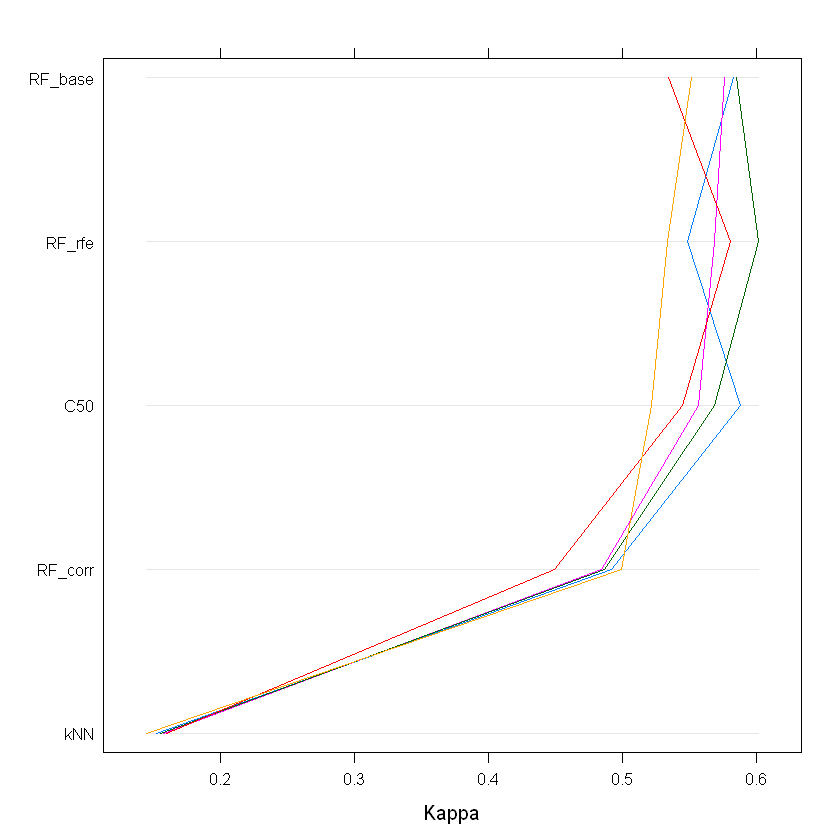

In [29]:
parallelplot(modeldata, metric = "Kappa")

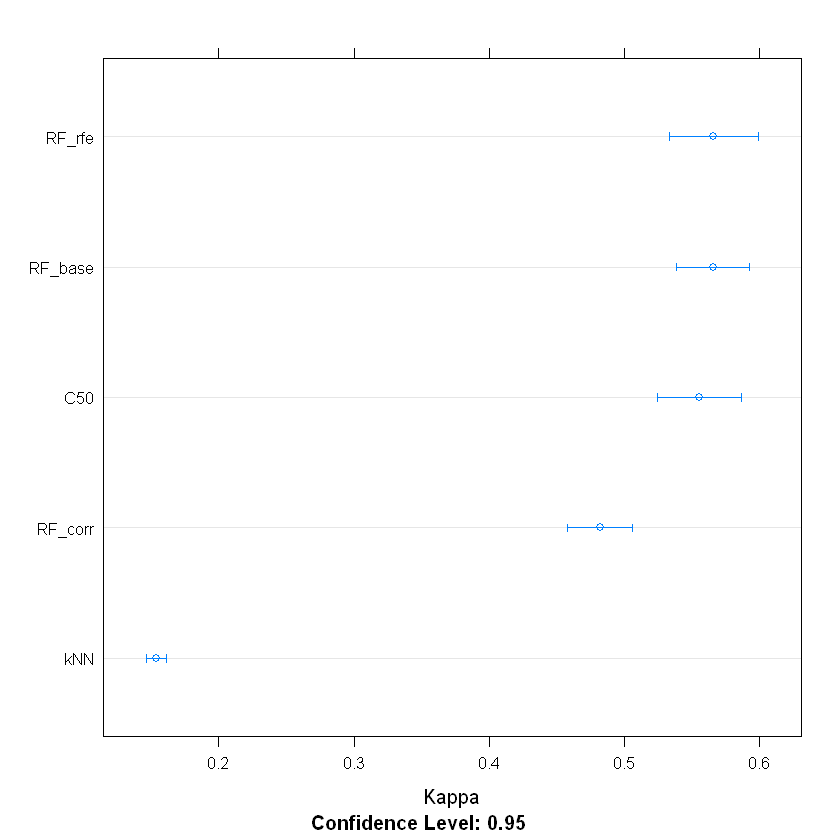

In [30]:
dotplot(modeldata, metric = "Kappa")

In [31]:
cmRF <- confusionMatrix(rfPred, testing$iphonesentiment) 
cmRF

Confusion Matrix and Statistics

          Reference
Prediction    0    1    2    3    4    5
         0  397    0    1    0    4    3
         1    0    1    0    0    0    0
         2    0    0   20    0    0    2
         3    2    0    3  222    3    9
         4    3    0    1    4  137   13
         5  186  116  111  130  287 2235

Overall Statistics
                                          
               Accuracy : 0.7743          
                 95% CI : (0.7608, 0.7873)
    No Information Rate : 0.5815          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5624          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0  Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity            0.6752 0.0085470 0.147059  0.62360  0.31787   0.9881
Specificity            0.9976 1.0000000 0.999467  0.99519  0.99393   0.4902
Po

<b>Feature Engineering</b>

In [32]:
library('dplyr')

# create a new dataset that will be used for recoding sentiment
iphoneRC <- iphone

# recode sentiment to combine factor levels 0 & 1 and 4 & 5
iphoneRC$iphonesentiment <- recode(iphoneRC$iphonesentiment, '0' = 1, '1' = 1, '2' = 2, '3' = 3, '4' = 4, '5' = 4) 

# inspect results
summary(iphoneRC)
str(iphoneRC)

# make iphonesentiment a factor
iphoneRC$iphonesentiment <- as.factor(iphoneRC$iphonesentiment)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




     iphone       samsunggalaxy       sonyxperia       nokialumina      
 Min.   : 0.000   Min.   :0.00000   Min.   :0.00000   Min.   :0.000000  
 1st Qu.: 1.000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.000000  
 Median : 1.000   Median :0.00000   Median :0.00000   Median :0.000000  
 Mean   : 2.148   Mean   :0.07115   Mean   :0.02405   Mean   :0.002312  
 3rd Qu.: 1.000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.000000  
 Max.   :46.000   Max.   :8.00000   Max.   :8.00000   Max.   :2.000000  
    htcphone             ios         googleandroid      iphonecampos     
 Min.   :  0.0000   Min.   :0.0000   Min.   :0.00000   Min.   :  0.0000  
 1st Qu.:  0.0000   1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:  0.0000  
 Median :  0.0000   Median :0.0000   Median :0.00000   Median :  0.0000  
 Mean   :  0.1371   Mean   :0.1523   Mean   :0.03962   Mean   :  0.2896  
 3rd Qu.:  0.0000   3rd Qu.:0.0000   3rd Qu.:0.00000   3rd Qu.:  0.0000  
 Max.   :479.0000   Max.   :6.0000   Max.   :

'data.frame':	12973 obs. of  59 variables:
 $ iphone         : int  1 1 1 1 1 41 1 1 1 1 ...
 $ samsunggalaxy  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonyxperia     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokialumina    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htcphone       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ios            : int  0 0 0 0 0 6 0 0 0 0 ...
 $ googleandroid  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecampos   : int  0 0 0 0 0 1 1 0 0 0 ...
 $ samsungcampos  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycampos     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacampos    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccampos      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamneg   : int  0 0 0 0 0 3 1 0 0 0 ...
 $ samsungcamneg  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamneg     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacamneg    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccamneg      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamunc   : int  0 0 0 0 0 7 1 0 0 0 ...
 $ samsungcamunc  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamunc     : int  

In [33]:
# Apply Random Forest to recoded dataset

partition_rc <- createDataPartition(iphoneRC$iphonesentiment, p = .70, list = FALSE)

training_rc <- iphoneRC[partition_rc,]
testing_rc <- iphoneRC[-partition_rc,]

# Train Random Forest model

rcFit <- train(iphonesentiment~., data = training_rc, method = "rf", metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

rcPred <- predict(rcFit, testing_rc)

postResample(rcPred, testing_rc$iphonesentiment)

Accuracy     Kappa 
0.8508997 0.6299269

In [34]:
cmRFrc <- confusionMatrix(rcPred, testing_rc$iphonesentiment) 
cmRFrc

Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4
         1  397    1    2   14
         2    0   12    0    0
         3    4    1  234   12
         4  304  122  120 2667

Overall Statistics
                                         
               Accuracy : 0.8509         
                 95% CI : (0.8393, 0.862)
    No Information Rate : 0.6923         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6299         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.5631 0.088235  0.65730   0.9903
Specificity            0.9947 1.000000  0.99519   0.5439
Pos Pred Value         0.9589 1.000000  0.93227   0.8301
Neg Pred Value         0.9114 0.968025  0.96647   0.9616
Prevalence             0.1812 0.034961  0.09152   0.6923
Detection Rate         0.1021

Accuracy increased significantly, as well as a kappa score.

PCA

In [35]:
# data = training and testing from iphoneDF (no feature selection) 
# create object containing centered, scaled PCA components from training set
# excluded the dependent variable and set threshold to .95

preprocessParams <- preProcess(training[,-59], method=c("center", "scale", "pca"), thresh = 0.95)

print(preprocessParams)

Created from 9083 samples and 58 variables

Pre-processing:
  - centered (58)
  - ignored (0)
  - principal component signal extraction (58)
  - scaled (58)

PCA needed 24 components to capture 95 percent of the variance


In [36]:
# use predict to apply pca parameters, create training, exclude dependant
train.pca <- predict(preprocessParams, training[,-59])

# add the dependent to training
train.pca$iphonesentiment <- training$iphonesentiment

# use predict to apply pca parameters, create testing, exclude dependant
test.pca <- predict(preprocessParams, testing[,-59])

# add the dependent to training
test.pca$iphonesentiment <- testing$iphonesentiment

# inspect results
str(train.pca)
str(test.pca)

'data.frame':	9083 obs. of  25 variables:
 $ PC1            : num  -0.692 -0.536 -0.633 -0.692 -0.692 ...
 $ PC2            : num  0.00637 -0.01305 0.00136 0.00637 0.00637 ...
 $ PC3            : num  -0.4724 -0.0231 -0.2996 -0.4724 -0.4724 ...
 $ PC4            : num  0.33 0.143 0.259 0.33 0.33 ...
 $ PC5            : num  -0.157 -0.2 -0.151 -0.157 -0.157 ...
 $ PC6            : num  0.241 0.375 0.277 0.241 0.241 ...
 $ PC7            : num  -0.115 -0.184 -0.118 -0.115 -0.115 ...
 $ PC8            : num  -0.0731 0.094 0.0105 -0.0731 -0.0731 ...
 $ PC9            : num  -0.012 -0.0169 -0.0175 -0.012 -0.012 ...
 $ PC10           : num  0.134 0.121 0.125 0.134 0.134 ...
 $ PC11           : num  0.146 0.216 0.225 0.146 0.146 ...
 $ PC12           : num  -0.236 -0.237 -0.236 -0.236 -0.236 ...
 $ PC13           : num  -0.0508 0.023 -0.0153 -0.0508 -0.0508 ...
 $ PC14           : num  0.0289 0.0478 0.0409 0.0289 0.0289 ...
 $ PC15           : num  0.00968 0.09977 0.04373 0.00968 0.00968 ...


In [37]:
# Apply Random Forest to PCA transformed dataset

# Train Random Forest model

pcaFit <- train(iphonesentiment~., data = train.pca, method = "rf", metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

pcaPred <- predict(pcaFit, test.pca)

postResample(pcaPred, test.pca$iphonesentiment)

Accuracy     Kappa 
0.7634961 0.5447960

In [38]:
cmRFpca <- confusionMatrix(pcaPred, test.pca$iphonesentiment) 
cmRFpca

Confusion Matrix and Statistics

          Reference
Prediction    0    1    2    3    4    5
         0  401    0    6    8   13   23
         1    0    1    0    0    0    2
         2    3    1   20    0    0    9
         3    0    0    0  212    0    6
         4    5    0    1    4  129   15
         5  179  115  109  132  289 2207

Overall Statistics
                                          
               Accuracy : 0.7635          
                 95% CI : (0.7498, 0.7768)
    No Information Rate : 0.5815          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5448          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0  Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity            0.6820 0.0085470 0.147059  0.59551  0.29930   0.9757
Specificity            0.9849 0.9994699 0.996537  0.99830  0.99277   0.4939
Po

In [39]:
# Combine Recode + PCA

library('dplyr')

# create a new dataset that will be used for recoding sentiment
iphoneRC_PCA <- iphone

# recode sentiment to combine factor levels 0 & 1 and 4 & 5
iphoneRC_PCA$iphonesentiment <- recode(iphoneRC_PCA$iphonesentiment, '0' = 1, '1' = 1, '2' = 2, '3' = 3, '4' = 4, '5' = 4) 

# inspect results
summary(iphoneRC_PCA)
str(iphoneRC_PCA)

# make iphonesentiment a factor
iphoneRC_PCA$iphonesentiment <- as.factor(iphoneRC_PCA$iphonesentiment)

     iphone       samsunggalaxy       sonyxperia       nokialumina      
 Min.   : 0.000   Min.   :0.00000   Min.   :0.00000   Min.   :0.000000  
 1st Qu.: 1.000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.000000  
 Median : 1.000   Median :0.00000   Median :0.00000   Median :0.000000  
 Mean   : 2.148   Mean   :0.07115   Mean   :0.02405   Mean   :0.002312  
 3rd Qu.: 1.000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.000000  
 Max.   :46.000   Max.   :8.00000   Max.   :8.00000   Max.   :2.000000  
    htcphone             ios         googleandroid      iphonecampos     
 Min.   :  0.0000   Min.   :0.0000   Min.   :0.00000   Min.   :  0.0000  
 1st Qu.:  0.0000   1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:  0.0000  
 Median :  0.0000   Median :0.0000   Median :0.00000   Median :  0.0000  
 Mean   :  0.1371   Mean   :0.1523   Mean   :0.03962   Mean   :  0.2896  
 3rd Qu.:  0.0000   3rd Qu.:0.0000   3rd Qu.:0.00000   3rd Qu.:  0.0000  
 Max.   :479.0000   Max.   :6.0000   Max.   :

'data.frame':	12973 obs. of  59 variables:
 $ iphone         : int  1 1 1 1 1 41 1 1 1 1 ...
 $ samsunggalaxy  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonyxperia     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokialumina    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htcphone       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ios            : int  0 0 0 0 0 6 0 0 0 0 ...
 $ googleandroid  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecampos   : int  0 0 0 0 0 1 1 0 0 0 ...
 $ samsungcampos  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycampos     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacampos    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccampos      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamneg   : int  0 0 0 0 0 3 1 0 0 0 ...
 $ samsungcamneg  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamneg     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacamneg    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccamneg      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamunc   : int  0 0 0 0 0 7 1 0 0 0 ...
 $ samsungcamunc  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamunc     : int  

In [40]:
# use predict to apply pca parameters, create training, exclude dependant
trainRC.pca <- predict(preprocessParams, training_rc[,-59])

# add the dependent to training
trainRC.pca$iphonesentiment <- training_rc$iphonesentiment

# use predict to apply pca parameters, create testing, exclude dependant
testRC.pca <- predict(preprocessParams, testing_rc[,-59])

# add the dependent to training
testRC.pca$iphonesentiment <- testing_rc$iphonesentiment

# inspect results
str(trainRC.pca)
str(testRC.pca)

'data.frame':	9083 obs. of  25 variables:
 $ PC1            : num  -0.692 -0.633 -0.437 -0.692 -0.143 ...
 $ PC2            : num  0.00637 0.00136 -0.01744 0.00637 -0.15164 ...
 $ PC3            : num  -0.472 -0.3 0.225 -0.472 -0.771 ...
 $ PC4            : num  0.3297 0.2591 0.0376 0.3297 0.4416 ...
 $ PC5            : num  -0.157 -0.151 -0.185 -0.157 -0.417 ...
 $ PC6            : num  0.241 0.277 0.381 0.241 -0.59 ...
 $ PC7            : num  -0.115 -0.118 -0.111 -0.115 0.276 ...
 $ PC8            : num  -0.0731 0.0105 0.2859 -0.0731 0.7505 ...
 $ PC9            : num  -0.01204 -0.01752 -0.02888 -0.01204 0.00799 ...
 $ PC10           : num  0.134 0.125 0.129 0.134 0.691 ...
 $ PC11           : num  0.1462 0.2253 0.332 0.1462 -0.0717 ...
 $ PC12           : num  -0.236 -0.236 -0.244 -0.236 -0.651 ...
 $ PC13           : num  -0.0508 -0.0153 0.0778 -0.0508 0.6152 ...
 $ PC14           : num  0.0289 0.0409 0.0725 0.0289 0.1572 ...
 $ PC15           : num  0.00968 0.04373 0.13657 0.0096

In [41]:
# Apply Random Forest to RC + PCA transformed dataset

# Train Random Forest model

rc_pcaFit <- train(iphonesentiment~., data = trainRC.pca, method = "rf", metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

rc_pcaPred <- predict(rc_pcaFit, testRC.pca)

postResample(rc_pcaPred, testRC.pca$iphonesentiment)

Accuracy     Kappa 
0.8419023 0.6070594

Applying PCA do not improne neither Accuracy nor Kappa.

In [42]:
large_matrix = read.csv('LargeMatrix.csv')

In [43]:
large_matrix$iphonesentiment <- 0

In [44]:
# Predicting target values using recoded model:

Pred <- predict(rcFit, large_matrix)


In [45]:
large_matrix$iphonesentiment <- Pred

In [46]:
summary(Pred) 

1     2     3     4 
 9226   579  1428 10575

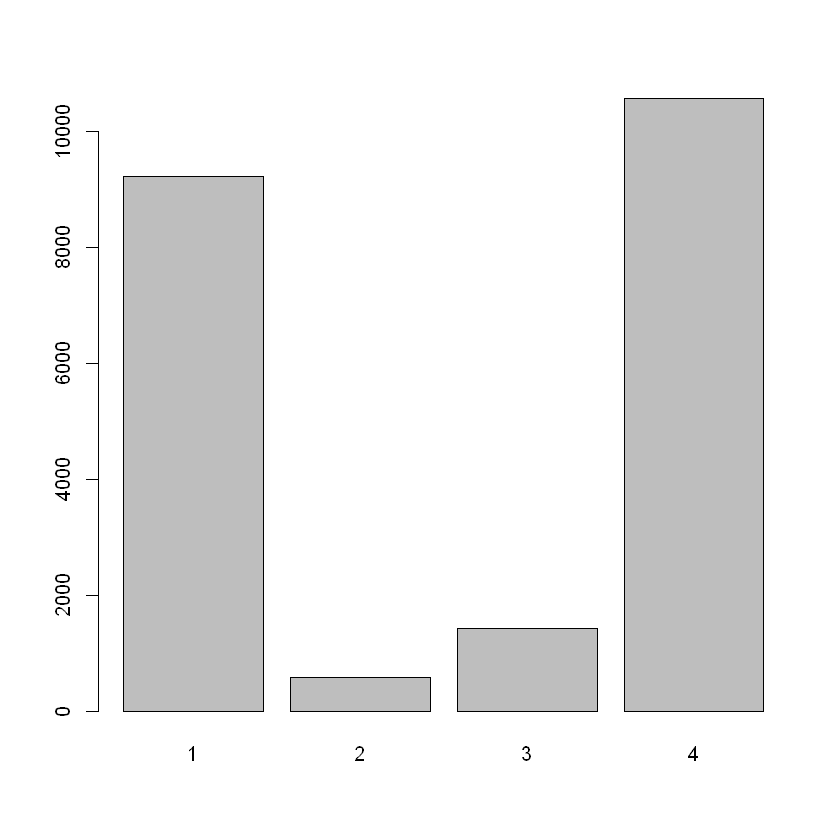

In [47]:
barplot(table(large_matrix$iphonesentiment))

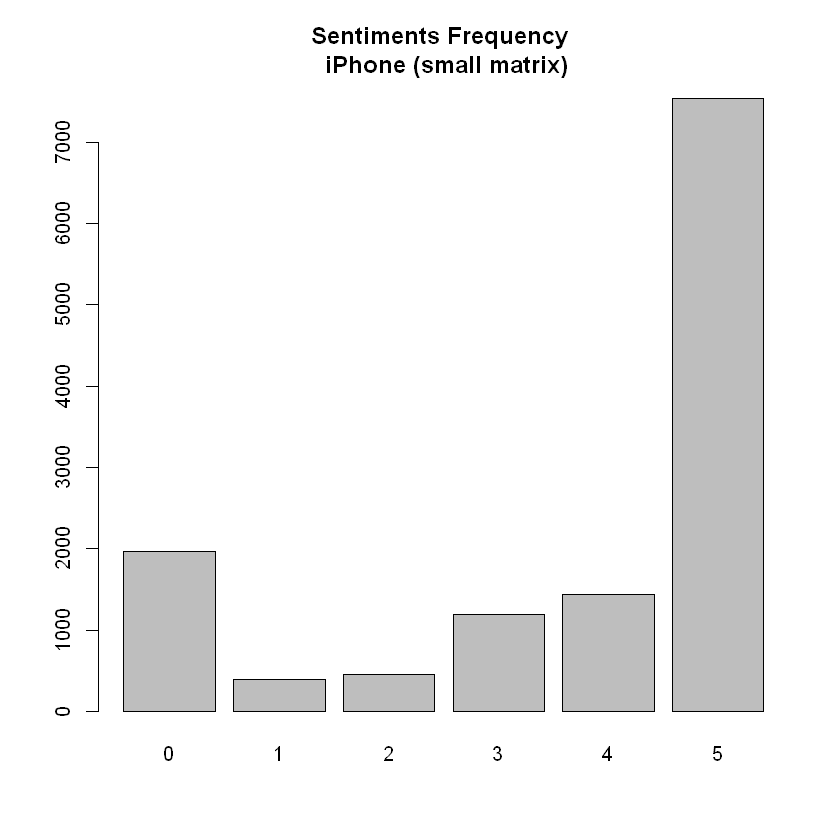

In [51]:
barplot(table(iphone$iphonesentiment), main = 'Sentiments Frequency \n iPhone (small matrix)')